# Final assignment

Due date : 7th December 2018

## Generative model for an image dataset

This final assignment covers the remainder of the course. The aims for the assignment are:
* Design, build, train and test a generative model of your choosing for either the CelebA dataset or the Fashion-MNIST dataset
* Explore more of Tensorflow or PyTorch’s functions for data processing and model building
* Write a report to summarise the research work carried out for this assignment
* Provide example generations from your trained model

This assignment is intentionally quite open-ended and has a lot of scope for different model choices; you are encouraged to dig deeper into the area that interests you the most.

## The dataset: either CelebA or Fashion-MNIST

### CelebA dataset

As a default, we recommend to use the CelebA dataset for this project. The dataset itself can be downloaded from [here](http://mmlab.ie.cuhk.edu.hk/projects/ "CelebA dataset"). (Note the dataset can also be downloaded from [Google Drive](https://drive.google.com/drive/folders/0B7EVK8r0v71pWEZsZE9oNnFzTm8 "CelebA dataset") or [Baidu Drive](https://pan.baidu.com/s/1eSNpdRG#list/path=%2FCelebA "CelebA dataset")). Make sure to download the aligned and cropped version of the dataset. In this version, the images have been roughly aligned using similarity transformation according to the two eye locations.

The dataset consists of over 20,000 images of celebrity faces, comprising 10,177 different identities. Each image is 178 x 218 pixels. In order to greatly simplify the learning task and reduce training time, you should downsample the dataset to something like 32 x 40 pixels. Additionally, feel free to convert the dataset to black and white.

### Fashion-MNIST dataset

Modelling the CelebA dataset will require more computing resources, and although it is possible to access free GPU compute time with Google Colab (see below), we would like to offer the option of using the Fashion-MNIST dataset, which is a much simpler dataset for this project. 

This dataset consists of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image. It is intended to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits. The dataset can be downloaded [here](https://github.com/zalandoresearch/fashion-mnist "Fashion-MNIST").

## Choice of generative model

In this course, we have covered several types of generative deep learning models: autoregressive models, variational autoencoders, generative adversarial networks and normalising flows. Each of these classes of generative models is actively researched and has a large and interesting body of literature to learn from. 

You are free to choose the type of generative model that interests you the most for this assignment. Part of the task is to explore more of the literature and experiment with some of the ideas and improvements that have been published. 

## Framework

In this course, we have covered the fundamentals of both Tensorflow and PyTorch. For this project, you can choose either of these frameworks.

If using Tensorflow, you may want to familiarise yourself with the Dataset API, and make use of the tfrecords format. This enables Tensorflow to work with large datasets that cannot fit in memory. We recommend to look at the [Tensorflow guide to importing data](https://www.tensorflow.org/guide/datasets).

## Google Colab

You may want to use GPUs for training your models for this assignment. You can get limited access to GPU hardware through Google Colab. It is easy to use and provides 12 hours at a time of GPU access. To get started with Colab, take a look through the [introductory notebook](https://colab.research.google.com/notebooks/welcome.ipynb).

## Submission

Your final project should be available to view in your own private repository, together with all other assignments from the course. You will be required to provide a link to your repository prior to the final oral examination.

### Code

All code used for the project should be included in your repository and clearly presented.

### Report

A required component of this assignment is to write a short summary report (around a couple of pages) of the process that you followed during the completion of this assignment. Make sure to include:

* Details of your final model architecture, including all hyperparameters, train/validation/test splits, optimizer used etc.
* Hyperparameter searches that you performed during the project, including your method of validation and corresponding results
* Model performance, metrics used and training curves for trained models
* Lessons learned and any other points of interest from your project

The report could be written in markdown format in your repository, or included as a pdf if you prefer.

### Example generations

Finally, include a selection of example generations from your model for evaluation. You should of course aim for high quality models and samples, but this is not the main aim of the project. The oral examination will focus on your understanding of the course material and the process you followed for this assignment.


# GANs on Fashion-MNIST

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision.utils import make_grid

from matplotlib import pyplot as plt
from IPython.display import clear_output
import pickle

In [2]:
# Growing Gan Model as described in [arXiv:1710.10196v3 [cs.NE] 26 Feb 2018]

class Up(nn.Module):
    
    def __init__(self, in_c, out_c):
        super().__init__()
        
        self.conv = nn.Conv2d(in_c, out_c, 5, padding=2)
        
    def forward(self, x):
        z = F.interpolate(x, scale_factor=2)
        return self.conv(z)
        
class ToRGB(nn.Module):
    
    def __init__(self, in_c, to_c=3):
        super().__init__()
        
        self.conv = nn.Conv2d(in_c, to_c, 1)
        
    def forward(self, x):
        return self.conv(x)
        
        
class FromRGB(nn.Module):
    
    def __init__(self, out_c, from_c=3):
        super().__init__()
        
        self.conv = nn.Conv2d(from_c, out_c, 1)
        
    def forward(self, x):
        return self.conv(x)
        
        
class Down(nn.Module):
    
    def __init__(self, in_c, out_c):
        super().__init__()
        
        self.conv = nn.Conv2d(in_c, out_c, 5, padding=2)
        
    def forward(self, x):
        x = self.conv(x)
        return F.interpolate(x, scale_factor=0.5)

In [3]:
# Model

class Generator(nn.Module):
    
    def __init__(self, rgb=True):
        super().__init__()
        
        self.layers = nn.ModuleList([
            Up(16, 16), # ->  8x8
            Up(16, 16), # -> 16x16
            Up(16, 16), # -> 32x32
            Up(16, 16), # -> 64x64
        ])
        
        self.affine = nn.Sequential(
            nn.Linear(16*4*4, 256),
            nn.ReLU(),
            nn.Linear(256, 16*4*4),
            nn.ReLU()
        )
        
        self.to_rgb = ToRGB(16, 3 if rgb else 1)
        
    def prior(self, batch_n=1):
        return torch.randn(batch_n, 16*4*4)
        
    def forward(self, batch_n=1, max_layer=4, alpha=1):
        z = self.prior(batch_n)
        z = self.affine(z).view(-1, 16, 4, 4)
        for layer in self.layers[:max_layer-1]:
            z = layer(z)
            z = F.relu(z)
        if alpha == 1:
            z = self.layers[max_layer-1](z)
            return torch.sigmoid(self.to_rgb(z))
        else:
            z_old = F.interpolate(torch.sigmoid(self.to_rgb(z)), scale_factor=2)
            z = self.layers[max_layer-1](z)
            z = torch.sigmoid(self.to_rgb(z))
            return z * alpha + z_old * (1-alpha)

In [4]:
# Critic

class Critic(nn.Module):
    
    def __init__(self, rgb=True):
        super().__init__()
        
        self.layers = nn.ModuleList([
            Down(16, 16), # <-  8x8
            Down(16, 16), # <- 16x16
            Down(16, 16), # <- 32x32
            Down(16, 16), # <- 64x64
        ])
        
        self.from_rgb = FromRGB(16, 3 if rgb else 1)
        
        self.affine = nn.Sequential(
            nn.Linear(16*4*4, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, max_layer=4, alpha=1):
        z = self.layers[max_layer-1](self.from_rgb(x))
        z = F.relu(z)
        if alpha < 1:
            z = self.from_rgb(F.interpolate(x, scale_factor=0.5)) * (1-alpha) + z * alpha
        for n in range(max_layer-1):
            z = self.layers[max_layer-n-1](z)
            z = F.relu(z)
        return self.affine(z.view(-1, 16*4*4))

In [24]:
# Datasets at different resolutions
def create_loader(width, height):
    t = torchvision.transforms.Compose((
        torchvision.transforms.Resize((width, height)),
        torchvision.transforms.ToTensor(),
    ))
    dataset = torchvision.datasets.ImageFolder("./data/CelebA", transform=t)
    # dataset = torchvision.datasets.FashionMNIST("./data/FashionMNIST", download=True, transform=t)
    return torch.utils.data.DataLoader(dataset, batch_size=128)

In [6]:
# Loss function
def loss(c, fill=1.0):
    return F.binary_cross_entropy(c, torch.empty(sample.size(0), requires_grad=False).fill_(fill))

In [27]:
# Model and optimizer
model = Generator(rgb=True)
critic = Critic(rgb=True)

optim_g = torch.optim.Adam(model.parameters(), lr=1e-3)
optim_c = torch.optim.Adam(critic.parameters(), lr=1e-3)

losses_g = []
losses_var = []
losses_c = []

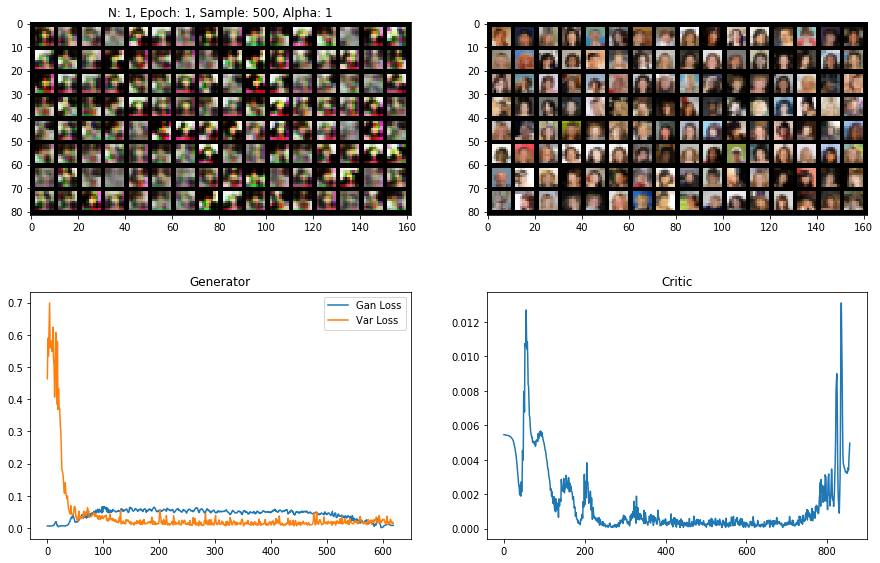

In [ ]:
# Training time...
resolutions = [8, 16, 32, 64]
epochs = 15 # per res.
k = 1
img_freq = 250

beta = 100.0

to_img = torchvision.transforms.ToPILImage()

for n, res in enumerate(resolutions):
    data_loader = create_loader(res, res)
    for epoch in range(1, epochs+1):
        for idx, (sample, _) in enumerate(data_loader):
            alpha = 1 if epoch > 1 else idx / len(data_loader) * 2
            if alpha > 1 or n == 0:
                alpha = 1
                
            # Generate fake images
            fake_sample = model(sample.size(0), n+1, alpha)
            critic_sample = critic(sample, n+1, alpha)
            critic_fake = critic(fake_sample, n+1, alpha)
            
            # Train the critic
            optim_c.zero_grad()
            
            loss_c = (loss(critic_sample, 1.0) + loss(critic_fake, 0.0)) / sample.size(0) / 2
            loss_c.backward(retain_graph=True)
            losses_c.append(loss_c.item())
            
            optim_c.step()
            
            # Train the generator
            if idx % k == 0:
                optim_g.zero_grad()
                
                loss_g = loss(critic_fake, 1.0) / sample.size(0)
                loss_var = alpha * beta * (torch.var(fake_sample, dim=0) - torch.var(sample, dim=0)).pow(2).sum() / sample.size(0)

                losses_g.append(loss_g.item())
                losses_var.append(loss_var.item())
                
                (loss_g + loss_var).backward()
                
                optim_g.step()
            
            # Generate sample
            if img_freq != 0 and idx % img_freq == 0:
                clear_output(wait=True)
                fig, ax = plt.subplots(2, 2, figsize=(15, 10))
                ax[0][0].set_title("N: {}, Epoch: {}, Sample: {}, Alpha: {}".format(n+1, epoch, idx, alpha))
                with torch.no_grad():
                    ax[0][0].imshow(to_img(make_grid(model(sample.size(0), n+1, alpha), nrow=16)), cmap="gray")
                    ax[0][1].imshow(to_img(make_grid(sample, nrow=16)), cmap="gray")
                    
                    ax[1][0].plot(losses_g, label="Gan Loss")
                    ax[1][0].plot(losses_var, label="Var Loss")
                    ax[1][1].plot(losses_c)

                    ax[1][0].set_title("Generator")
                    ax[1][1].set_title("Critic")
                    ax[1][0].legend()
                plt.show()

In [ ]:
# Save model parameters (for later use)
with open("./model_final_2.p", "wb") as f:
    pickle.dump(model.state_dict(), f)

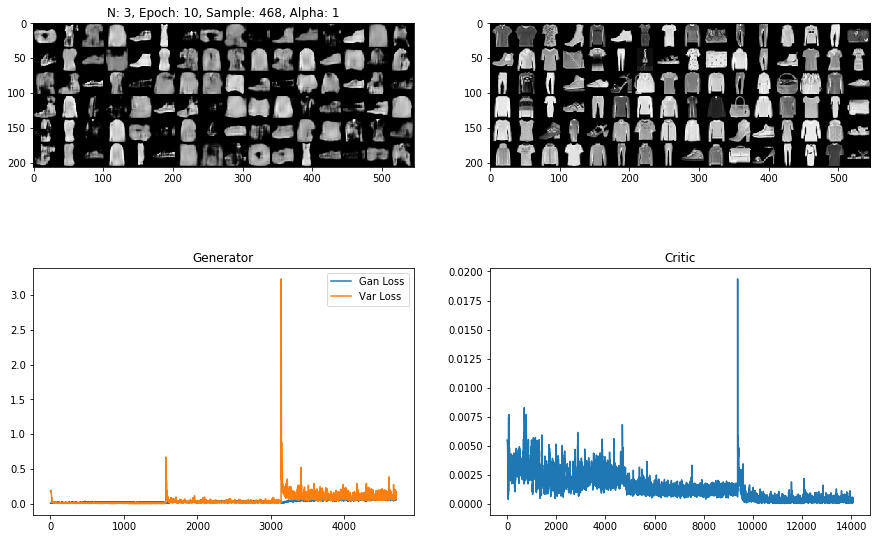

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax[0][0].set_title("N: {}, Epoch: {}, Sample: {}, Alpha: {}".format(n+1, epoch, idx, alpha))
with torch.no_grad():
    ax[0][0].imshow(to_img(make_grid(model(sample.size(0), n+1, alpha), nrow=16)), cmap="gray")
    ax[0][1].imshow(to_img(make_grid(sample, nrow=16)), cmap="gray")
                    
    ax[1][0].plot(losses_g, label="Gan Loss")
    ax[1][0].plot(losses_var, label="Var Loss")
    ax[1][1].plot(losses_c)

    ax[1][0].set_title("Generator")
    ax[1][1].set_title("Critic")
    ax[1][0].legend()
plt.show()

In [ ]:
len(create_loader(8, 8)), len(test), len(test)/len(create_loader(8,8))

In [ ]:
_, ax = plt.subplots(figsize=(15, 10))
ax.plot(test)
ax.axvline(x=498)
plt.show()

In [ ]:
_, ax = plt.subplots()
ax.imshow(to_img(model(1, 1, 1).squeeze()))
plt.show()